In [3]:
import librosa
import numpy as np
import soundfile as sf
import librosa.effects
from scipy.signal import convolve
import matplotlib.pyplot as plt
import os

In [4]:
def load_audio(file_path):

    y, sr = librosa.load(file_path, sr=None)
    return y, sr

In [18]:
def apply_pitch_shift(y, sr, n_steps=2):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)

In [6]:
def apply_hpss(y):

    y_harmonic, y_percussive = librosa.effects.hpss(y)
    return y_harmonic, y_percussive


In [7]:
def apply_reverb(y, sr, reverb_level=0.3):
   
    reverb_impulse = np.zeros(44100)
    reverb_impulse[0] = 1
    reverb_impulse[2205] = reverb_level 
    y_reverb = convolve(y, reverb_impulse, mode='same')
    return y_reverb

In [8]:
def apply_echo(y, sr, echo_level=0.4, delay=0.3):

    delay_samples = int(delay * sr)
    echo_signal = np.zeros_like(y)
    echo_signal[delay_samples:] = y[:-delay_samples]
    y_echo = y + echo_level * echo_signal
    return y_echo

In [9]:
def recombine_audio(harmonic, percussive, pitch_shifted, reverb_audio, echo_audio):


    min_length = min(len(harmonic), len(percussive), len(pitch_shifted), len(reverb_audio), len(echo_audio))
    harmonic = harmonic[:min_length]
    percussive = percussive[:min_length]
    pitch_shifted = pitch_shifted[:min_length]
    reverb_audio = reverb_audio[:min_length]
    echo_audio = echo_audio[:min_length]

    
    mixed_audio = harmonic + percussive + pitch_shifted + reverb_audio + echo_audio

    mixed_audio = mixed_audio / np.max(np.abs(mixed_audio))
    return mixed_audio

In [15]:
dataset_path = "musdb18/valid"  
output_path = "test_remix_data"

In [16]:
os.makedirs(output_path, exist_ok=True)

In [11]:
components = ['vocals', 'drums', 'bass', 'other']

music_folder = "The Districts - Vermont" 
final_mixed_audio = None

In [19]:
for component in components:
    component_path = f"{dataset_path}/{music_folder}/{component}.wav"
    
    y, sr = load_audio(component_path)
    
    y_pitch_shifted = apply_pitch_shift(y, sr, n_steps=2)
    y_harmonic, y_percussive = apply_hpss(y)
    y_reverb = apply_reverb(y, sr)
    y_echo = apply_echo(y, sr)
    
    remixed_component = recombine_audio(
        y_harmonic, y_percussive, y_pitch_shifted, y_reverb, y_echo
    )
    
    if final_mixed_audio is None:
        final_mixed_audio = remixed_component
    else:
        final_mixed_audio += remixed_component

In [20]:
final_mixed_audio = final_mixed_audio / np.max(np.abs(final_mixed_audio))

In [21]:
output_file_path = f"{output_path}/{music_folder}_final_remixed.wav"
sf.write(output_file_path, final_mixed_audio, sr)

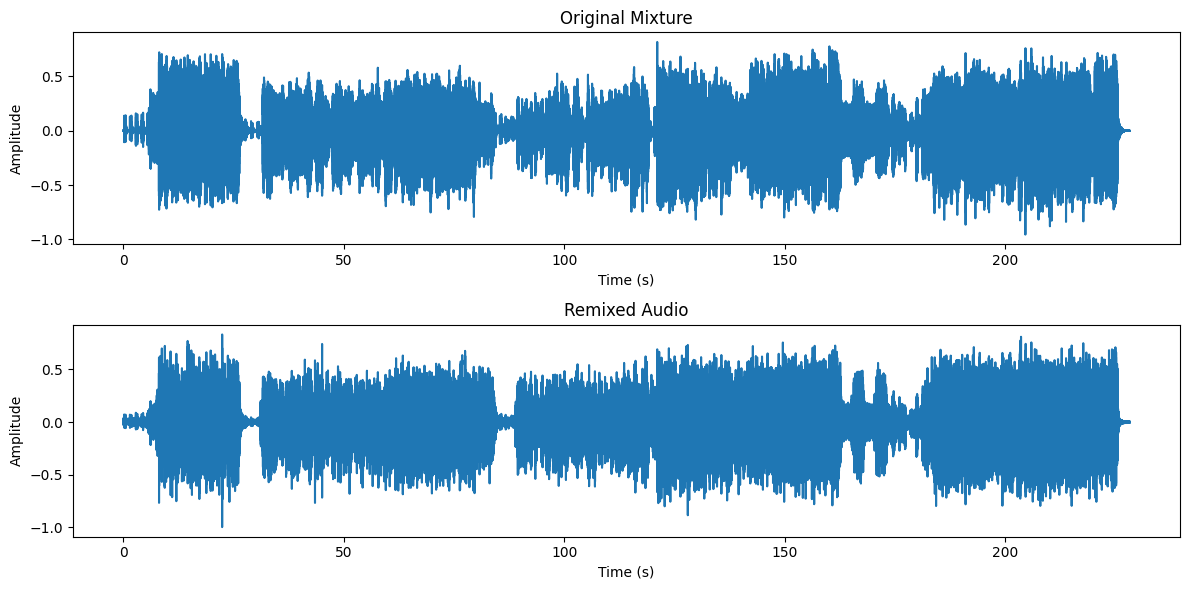

Final remixed track saved to: test_remix_data/The Districts - Vermont_final_remixed.wav


In [23]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

original_mixture_path = "musdb18/valid/The Districts - Vermont/mixture.wav"  

y, sr = librosa.load(original_mixture_path, sr=None)  

time_original = np.linspace(0, len(y) / sr, len(y)) 
time_remixed = np.linspace(0, len(final_mixed_audio) / sr, len(final_mixed_audio))  

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.title("Original Mixture")
plt.plot(time_original, y)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.title("Remixed Audio")
plt.plot(time_remixed, final_mixed_audio)  
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

print(f"Final remixed track saved to: {output_file_path}")
